# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult over age 18, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include Social Security, SNAP, WIC, SSI, TANF, WIC, housing benefits, and "other benefits" included in C-TAM. It does not include Medicare, Medicaid, or veteran's benefits.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
recs = tc.Records.cps_constructor()

In [7]:
BENS = ['other_ben', 'snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'housing_ben',
        'e02400'  # OASDI.
       ]

In [8]:
base = tch.calc_df(records=recs, year=2019, 
                   group_vars=['XTOT', 'nu18'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [9]:
UBI = 12000
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.XTOT - base.nu18
base['ubi_max'] = base.adults * UBI
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)

Weight.

In [10]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6
base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6

In [11]:
base.ubi_m.sum()

2272396.1144399997

In [12]:
base.ubi_max_m.sum()

2970909.8827200015

In [13]:
base.ubi_max_m.sum() - base.ubi_m.sum()

698513.7682800018

In [14]:
base.bens_m.sum()

1552832.407484551

In [15]:
base.bens_yang_m.sum()

363953.3765214061

In [16]:
tch.weighted_sum(base, 'other_ben') / 1e9

288.04924511373207

In [17]:
base[(base.ubi + base.e02400 == 0)].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,other_ben,snap_ben,ssi_ben,tanf_ben,wic_ben,housing_ben,e02400
RECID,,,,,,,,,,,,,
260397,4.0,1.0,12000.0,0.0,24784.6,0.0,15803.0,8018.03,0.0,0.0,963.57,0.0,0.0


In [18]:
base[base.ubi == 0].sample()[['XTOT', 'adults', 'ubi_max', 'ubi', 'bens', 'bens_yang'] + BENS]

,XTOT,adults,ubi_max,ubi,bens,bens_yang,other_ben,snap_ben,ssi_ben,tanf_ben,wic_ben,housing_ben,e02400
RECID,,,,,,,,,,,,,
227927,2.0,2.0,24000.0,0.0,39437.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39437.01


### VAT

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [19]:
TOTAL_VAT = 800e9
VAT_INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 20, 40, 60, 80, 90, 95, 99, 99.9],
    'rate': [3.9, 3.6, 3.6, 3.6, 3.4, 3.2, 2.8, 2.5, 2.5]
})
VAT_INCIDENCE.rate /= 100

In [20]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [21]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

16467.878021415047

In [22]:
tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')

In [23]:
base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
    pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
           bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [24]:
base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale

In [25]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.6243280377912117

In [26]:
2.3e12 / tch.weighted_sum(base, 'vat_base')

4.669943108649734

In [27]:
base['vat'] = base.vat_base * vat_mult
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6

In [28]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [29]:
tch.gini(base.aftertax_income, base.s006)

0.4510243607360635

In [30]:
tch.gini(base.afti_yang, base.s006)

0.40213641704913383

In [31]:
base.afti_yang.describe()

count    4.56e+05
mean     1.43e+05
std      1.53e+06
min     -3.11e+06
25%      4.99e+04
50%      9.43e+04
75%      1.73e+05
max      1.02e+09
Name: afti_yang, dtype: float64

In [32]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [33]:
'${} billion shortfall'.format((base.afti_chg_m.sum() / 1e6).round(2))

'$1.47 billion shortfall'

### Revenue-neutral

In [34]:
def deficit_by_ubi(ubi=UBI, total_vat=TOTAL_VAT, data=base):
    base = data.copy(deep=True)
    base['bens'] = base[BENS].sum(axis=1)
    base['adults'] = base.XTOT - base.nu18
    base['ubi_max'] = base.adults * ubi
    base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
    base['bens_yang'] = np.where(base.ubi > 0, base.bens, 0)
    base['ubi_m'] = base.ubi * base.s006 / 1e6
    base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
    base['bens_m'] = base.bens * base.s006 / 1e6
    base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
    base['afti_yang_prevat'] = base.aftertax_income + base.ubi
    base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)
    tch.add_weighted_quantiles(base, 'afti_yang_prevat_noneg')
    base['vat_rate_prescale'] = VAT_INCIDENCE.rate[
        pd.cut(base.afti_yang_prevat_noneg_percentile_exact,
               bins=VAT_INCIDENCE.income_percentile_floor.tolist() + [100],
               labels=False)].values
    base['vat_base'] = base.afti_yang_prevat_noneg * base.vat_rate_prescale
    vat_mult = total_vat / tch.weighted_sum(base, 'vat_base')
    base['vat'] = base.vat_base * vat_mult
    base['vat_m'] = tch.weight(base, 'vat') / 1e6
    base['afti_yang_prevat_noneg_m'] = tch.weight(base, 'afti_yang_prevat_noneg') / 1e6
    base['afti_yang'] = base.afti_yang_prevat - base.vat
    base['afti_chg'] = base.afti_yang - base.aftertax_income
    return pd.DataFrame({'ubi': [ubi],
                         'total_vat': [total_vat],
                         'deficit': [tch.weighted_sum(base, 'afti_chg')]})

In [35]:
deficits_l = []
for i in np.arange(0, TOTAL_VAT * 4, 1e11):
    deficits_l.append(deficit_by_ubi(total_vat=i))
for i in np.arange(0, UBI+1, 120):
    deficits_l.append(deficit_by_ubi(ubi=i))
deficits = pd.concat(deficits_l).drop_duplicates()

In [36]:
deficits['abs_deficit'] = np.abs(deficits.deficit)
deficits['ubi_monthly'] = deficits.ubi / 12

In [37]:
deficits.sort_values('abs_deficit').head()

,ubi,total_vat,deficit,abs_deficit,ubi_monthly
0,5160,8.00e+11,5.00e+09,5.00e+09,430.0
0,5040,8.00e+11,-1.68e+10,1.68e+10,420.0
0,12000,2.30e+12,-2.76e+10,2.76e+10,1000.0
0,5280,8.00e+11,2.78e+10,2.78e+10,440.0
0,4920,8.00e+11,-3.86e+10,3.86e+10,410.0


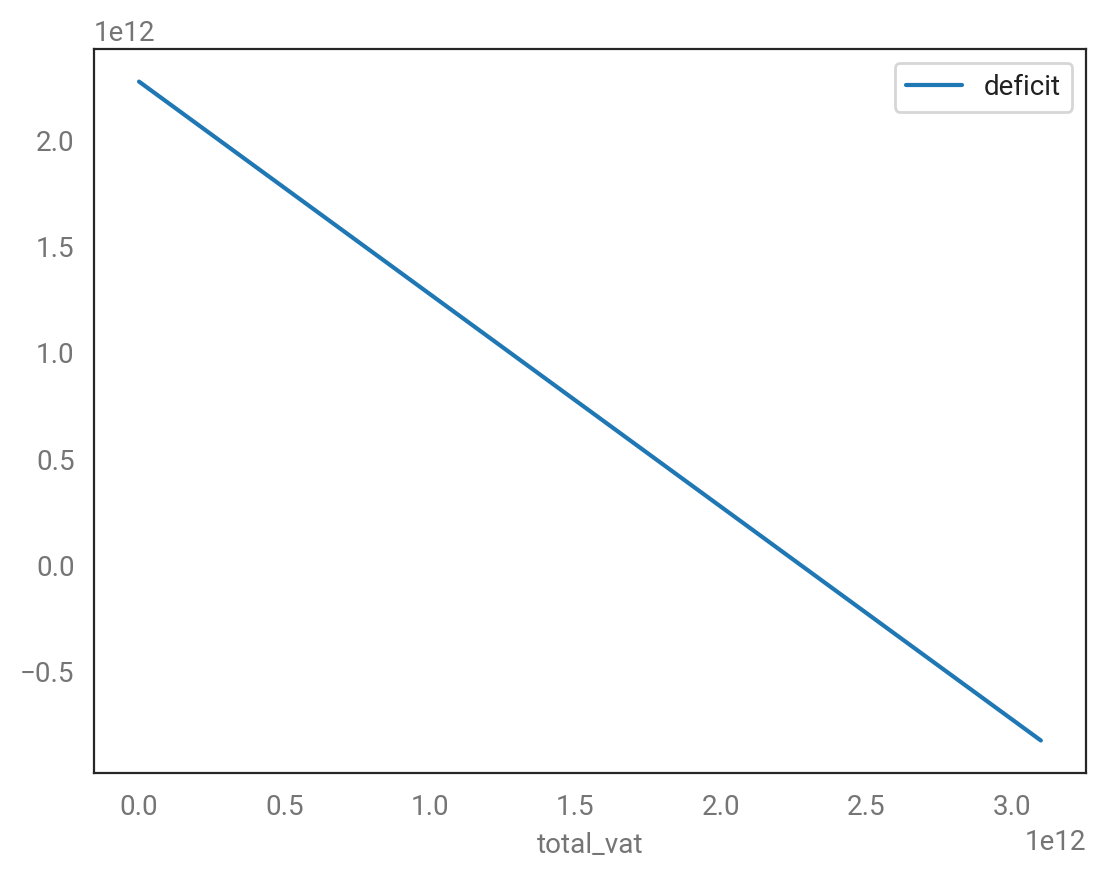

In [38]:
deficits[deficits.ubi == UBI].sort_values('total_vat').plot('total_vat', 'deficit')

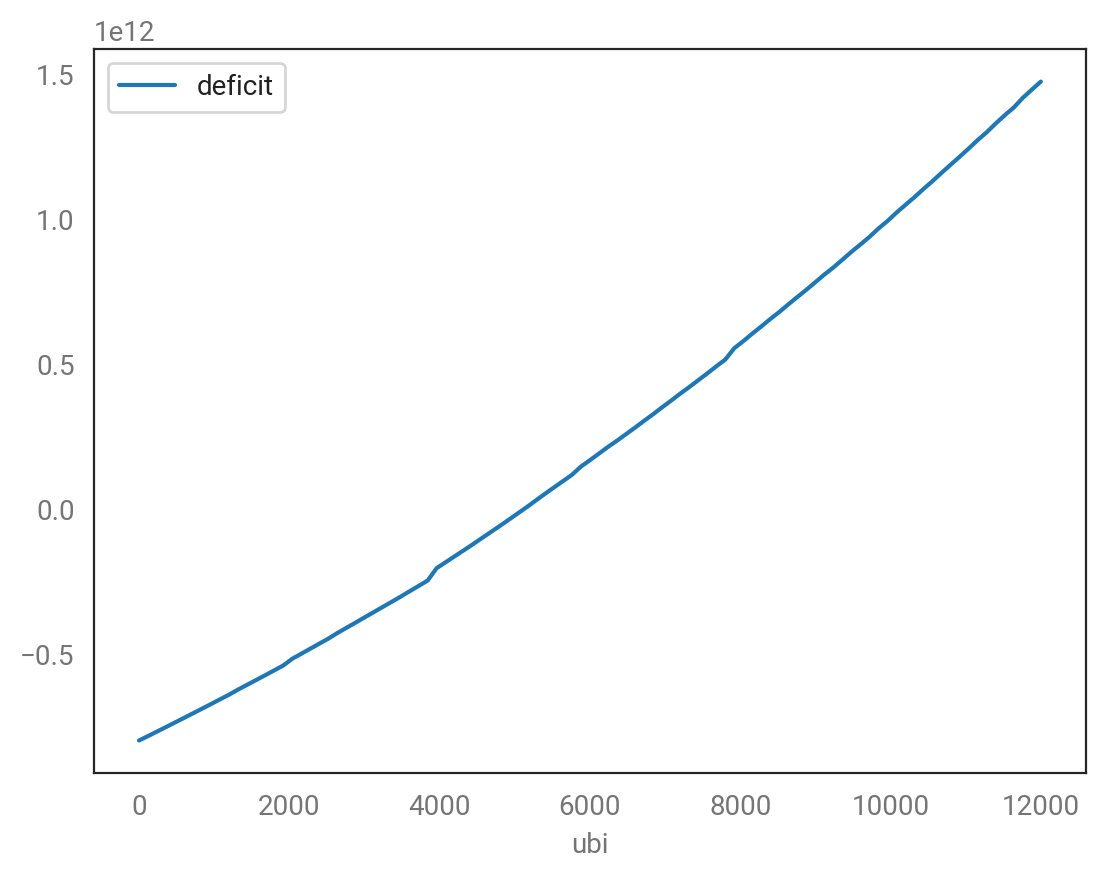

In [39]:
deficits[deficits.total_vat == TOTAL_VAT].drop_duplicates().sort_values('ubi').plot('ubi', 'deficit')
plt.show()

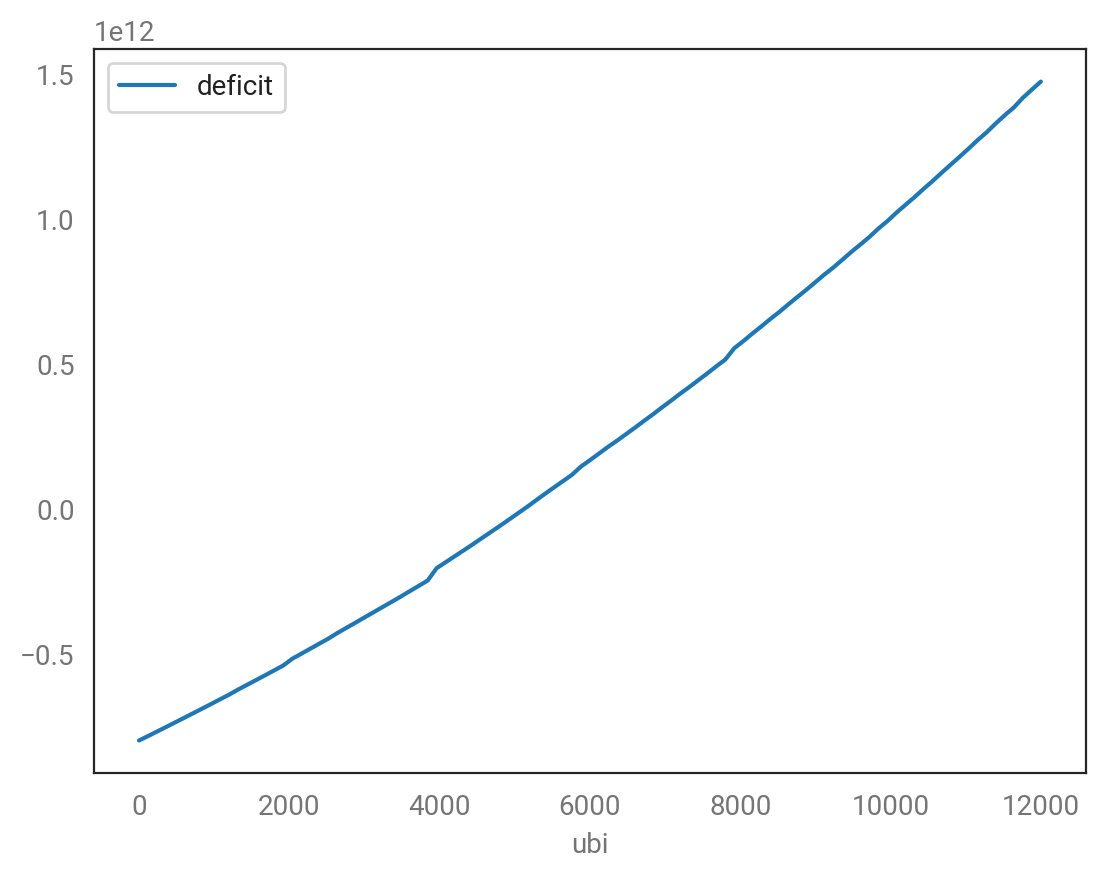

In [40]:
deficits[deficits.total_vat == TOTAL_VAT].drop_duplicates().sort_values('ubi').plot('ubi', 'deficit')

In [41]:
5100/12

425.0

## Analysis

### Benefit reductions

In [42]:
ben_reduction_l = []
for i in BENS:
    tmp = pd.DataFrame({
        'base': [tch.weighted_sum(base, i)],
        'yang': [tch.weighted_sum(base[base.ubi > 0], i)]
    }, index=[i])
    ben_reduction_l.append(tmp)
ben_reduction = pd.concat(ben_reduction_l)
ben_reduction['reduction'] = ben_reduction.base - ben_reduction.yang
ben_reduction['pct_reduction'] = ben_reduction.reduction / ben_reduction.base
ben_reduction

,base,yang,reduction,pct_reduction
other_ben,2.88e+11,1.32e+11,1.56e+11,0.54
snap_ben,8.76e+10,3.52e+10,5.24e+10,0.60
ssi_ben,5.23e+10,5.28e+09,4.70e+10,0.90
tanf_ben,2.99e+10,1.13e+10,1.86e+10,0.62
wic_ben,3.71e+09,1.92e+09,1.79e+09,0.48
housing_ben,3.68e+10,4.24e+09,3.26e+10,0.88
e02400,1.05e+12,1.74e+11,8.80e+11,0.84


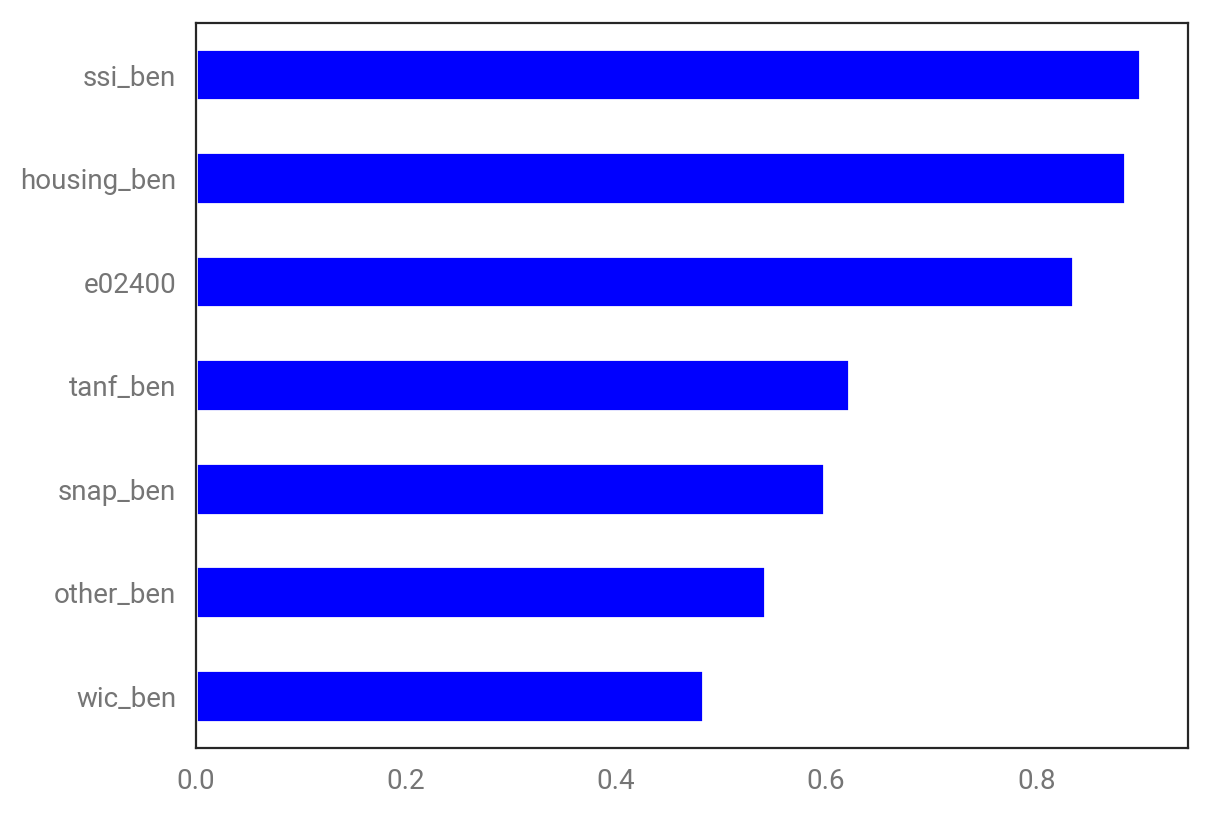

In [43]:
ben_reduction.sort_values('pct_reduction').pct_reduction.plot.barh(color='blue')
plt.show()

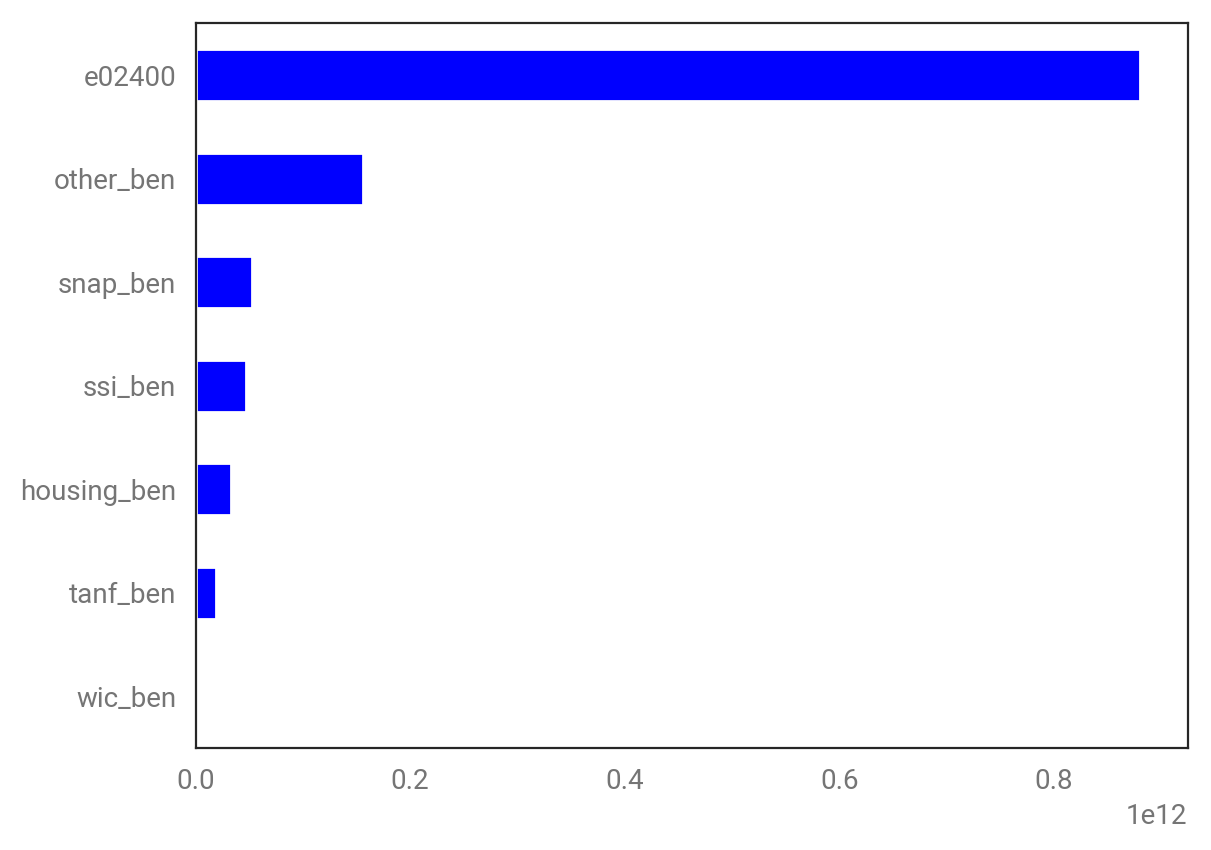

In [44]:
ben_reduction.sort_values('reduction').reduction.plot.barh(color='blue')
plt.show()

In [45]:
# base.sort_values('afti).head()

In [46]:
base.sort_values('afti_chg', ascending=False).head()

,snap_ben,s006,other_ben,XTOT,wic_ben,aftertax_income,tanf_ben,housing_ben,ssi_ben,e02400,...,afti_yang_prevat_noneg_quintile,afti_yang_prevat_noneg_quartile,vat_rate_prescale,vat_base,vat,vat_m,afti_yang_prevat_noneg_m,afti_yang,afti_chg,afti_chg_m
RECID,,,,,,,,,,,,,,,,,,,,,
167613,0.0,877.33,0.00,12.0,0.0,2935.90,0.0,0.0,0.00,0.00,...,5,4,0.03,4995.82,8114.85,7.12,128.91,138821.05,135885.15,119.22
206972,0.0,1101.02,10997.35,8.0,0.0,87675.55,0.0,0.0,5733.59,27240.64,...,5,4,0.03,5877.62,9547.18,10.51,202.23,174128.37,86452.82,95.19
21452,0.0,1128.44,23440.61,8.0,0.0,111172.48,0.0,0.0,0.00,1598.78,...,5,4,0.03,6629.52,10768.51,12.15,233.78,196403.96,85231.49,96.18
388397,0.0,550.97,0.00,7.0,0.0,0.00,0.0,0.0,0.00,0.00,...,4,3,0.04,3024.00,4911.97,2.71,46.28,79088.03,79088.03,43.58
201246,0.0,107.18,0.00,7.0,0.0,20623.71,0.0,0.0,0.00,0.00,...,4,3,0.04,3766.45,6117.96,0.66,11.21,98505.75,77882.04,8.35


In [60]:
base.vat_m.sum() / base.afti_yang_prevat_noneg_m.sum()

0.05461048063464169

In [47]:
decile = base.groupby('aftertax_income_decile')['aftertax_income_m', 'afti_chg_m',
                                                'vat_m', 'afti_yang_prevat_noneg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile['vat'] = 1e6 * decile.vat_m / decile.s006
decile['vat_pct'] = decile.vat_m / decile.afti_yang_prevat_noneg_m
decile.drop(0, inplace=True)
decile

,aftertax_income_m,afti_chg_m,vat_m,afti_yang_prevat_noneg_m,s006,afti_chg,afti_chg_pct,vat,vat_pct
aftertax_income_decile,,,,,,,,,
1,1.65e+05,184539.35,23447.16,3.73e+05,1.65e+07,11200.03,1.12,1423.05,0.06
2,3.87e+05,176905.72,36870.08,6.00e+05,1.65e+07,10704.48,0.46,2230.99,0.06
3,5.18e+05,141496.23,41756.58,7.02e+05,1.65e+07,8562.15,0.27,2526.75,0.06
4,6.45e+05,143890.53,49267.64,8.38e+05,1.65e+07,8706.58,0.22,2981.11,0.06
5,7.93e+05,156675.36,58950.42,1.01e+06,1.65e+07,9480.62,0.20,3567.16,0.06
6,9.76e+05,145059.55,69622.49,1.19e+06,1.65e+07,8776.66,0.15,4212.43,0.06
7,1.21e+06,149077.36,84109.77,1.44e+06,1.65e+07,9020.84,0.12,5089.58,0.06
8,1.52e+06,150549.02,102461.24,1.77e+06,1.65e+07,9109.49,0.10,6199.77,0.06
9,2.03e+06,138186.77,127315.16,2.30e+06,1.65e+07,8361.54,0.07,7703.71,0.06


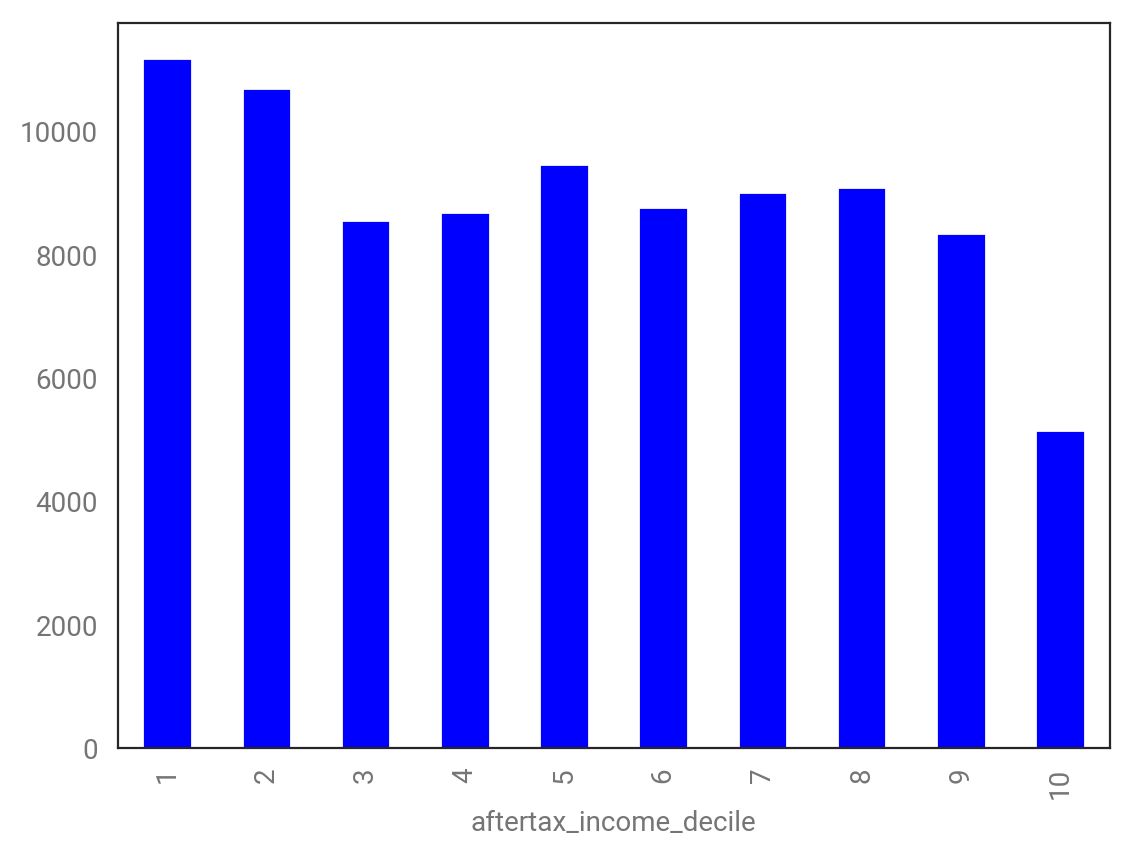

In [48]:
decile.afti_chg.plot.bar(color='blue')
plt.show()

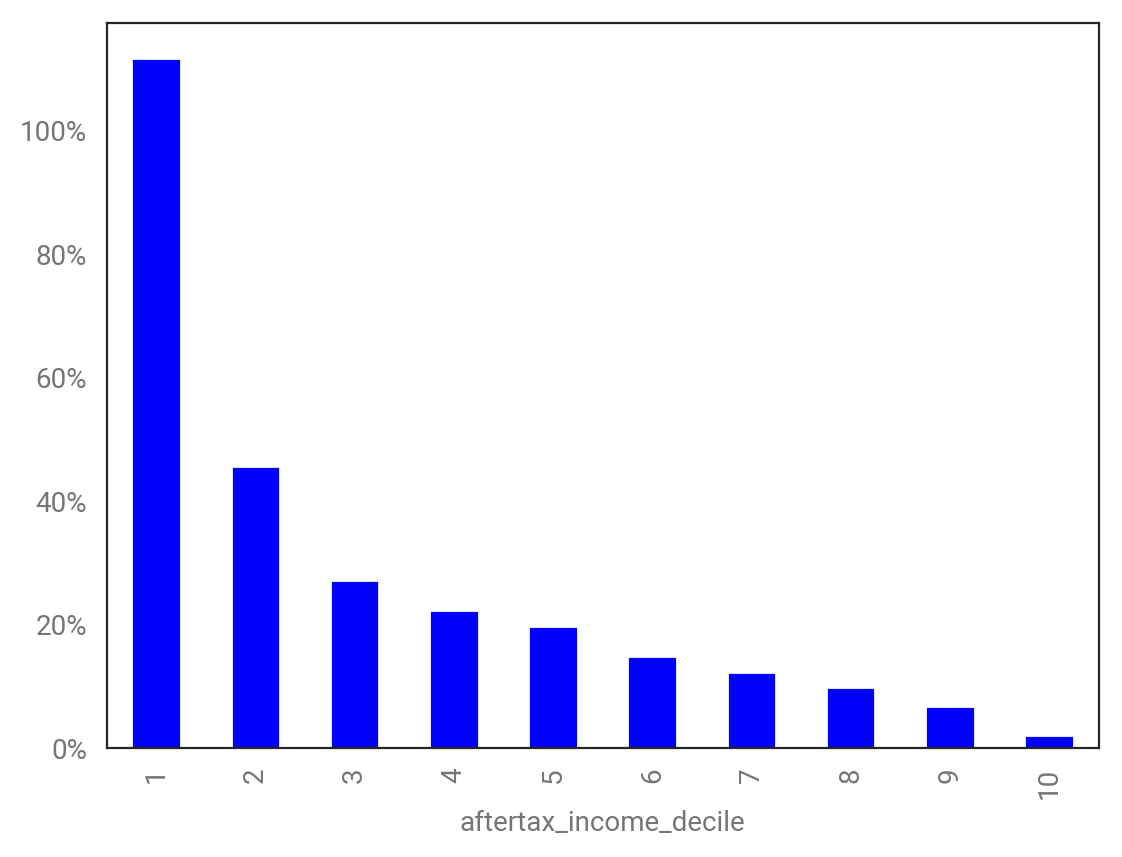

In [49]:
ax = decile.afti_chg_pct.plot.bar(color='blue')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

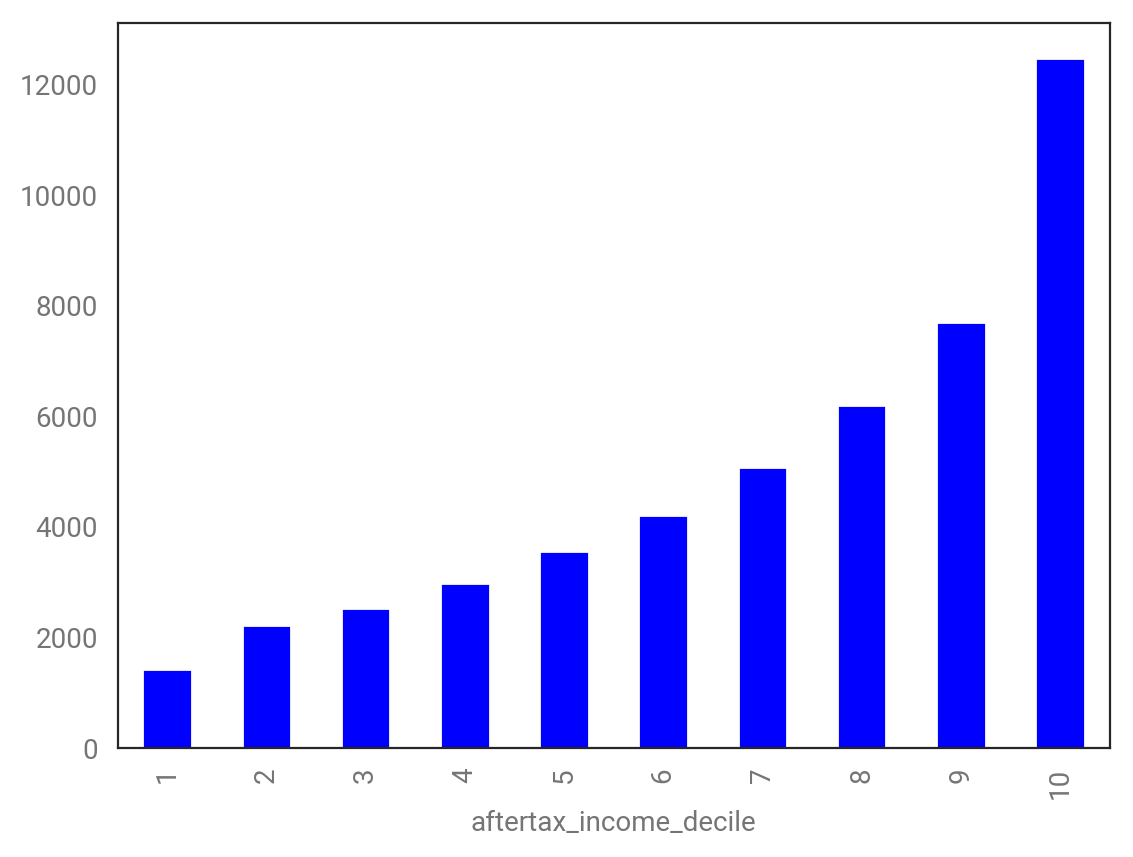

In [50]:
decile.vat.plot.bar(color='blue')
plt.show()

UBI skeptics point to issues that could arise under specific implementations, depending on their perspective: on the left, that it will increase poverty by reducing benefits, and on the right that it will reduce work incentives by raising marginal tax rates. How much is the UBI discussion hampered (or benefited) by the lack of a specific plan that could be analyzed?

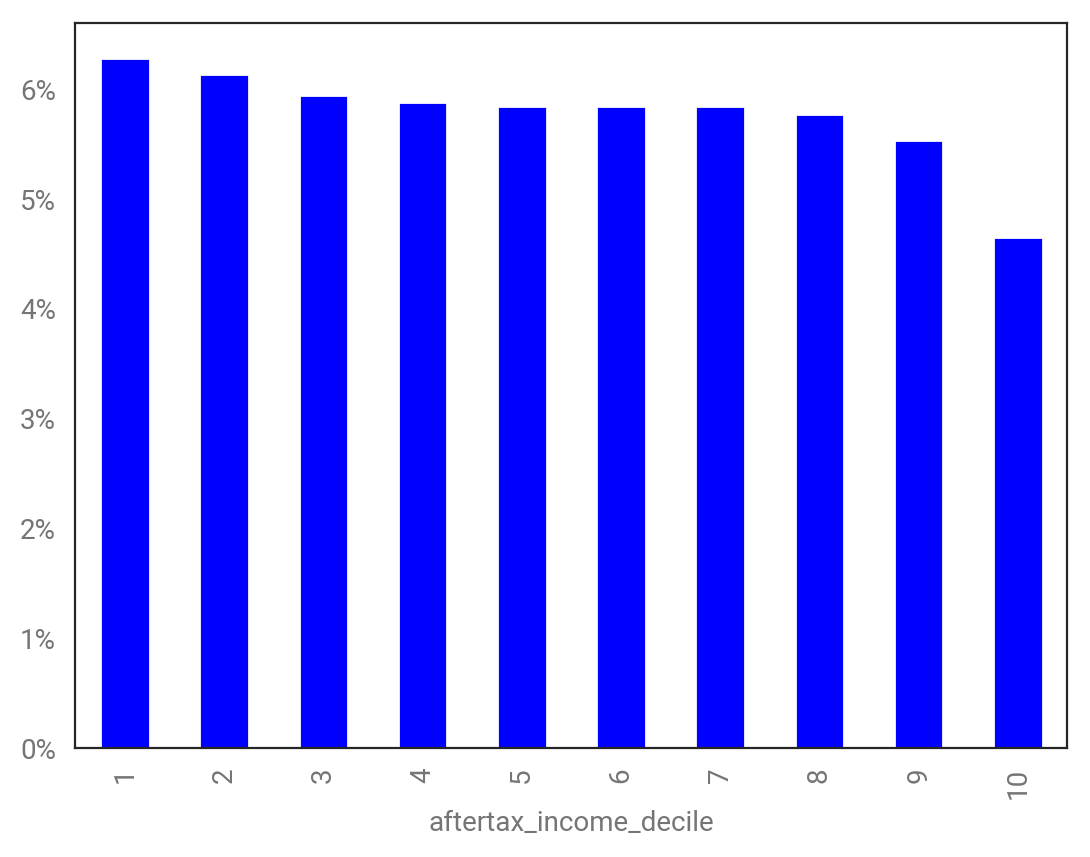

In [51]:
ax = decile.vat_pct.plot.bar(color='blue')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

In [52]:
ventile = base.groupby('aftertax_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile.drop(0, inplace=True)
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_ventile,,,,,
5,3.87e+04,93441.98,8.21e+06,11377.36,2.42e+00
10,1.26e+05,91097.37,8.26e+06,11023.79,7.20e-01
15,1.75e+05,92582.49,8.26e+06,11204.15,5.30e-01
20,2.12e+05,84323.23,8.26e+06,10204.81,3.98e-01
25,2.44e+05,72298.73,8.26e+06,8749.24,2.96e-01
30,2.74e+05,69197.50,8.26e+06,8375.03,2.52e-01
35,3.06e+05,69989.15,8.26e+06,8469.01,2.29e-01
40,3.39e+05,73901.39,8.26e+06,8944.21,2.18e-01
45,3.76e+05,78750.44,8.26e+06,9530.03,2.09e-01


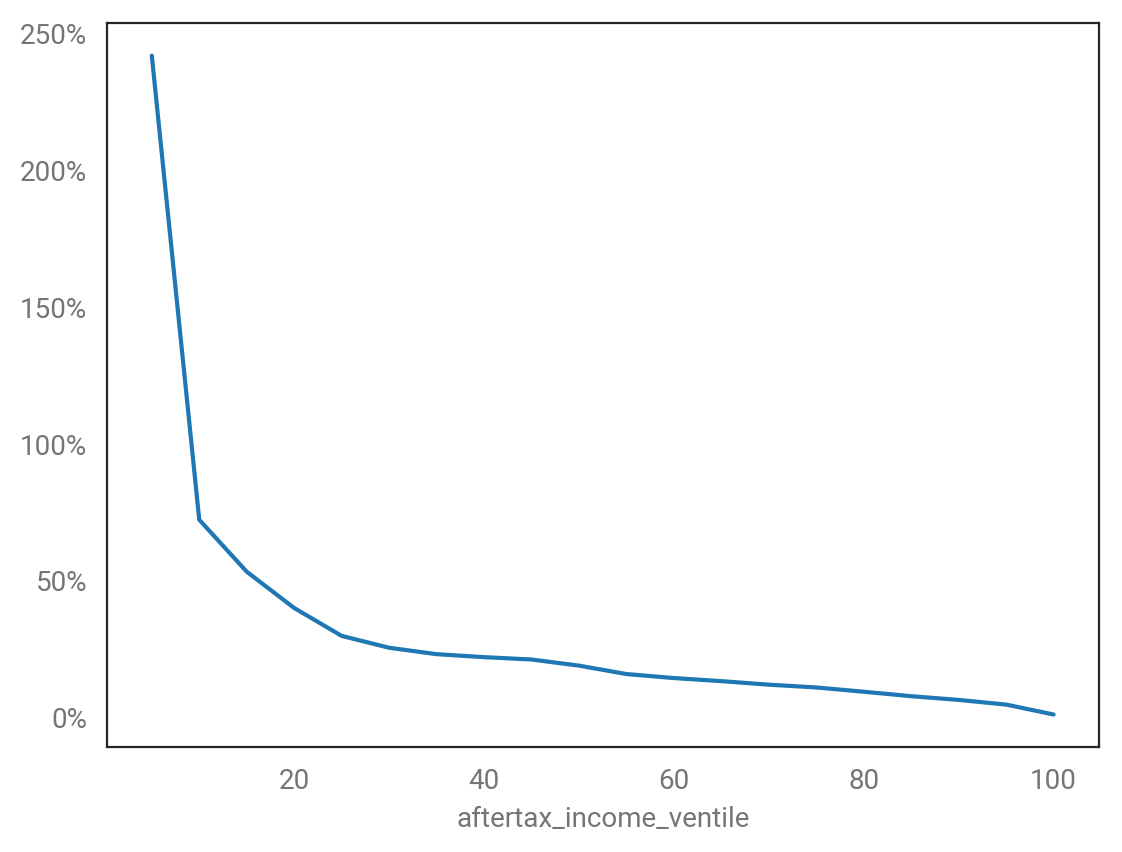

In [53]:
ax = ventile.afti_chg_pct.plot()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

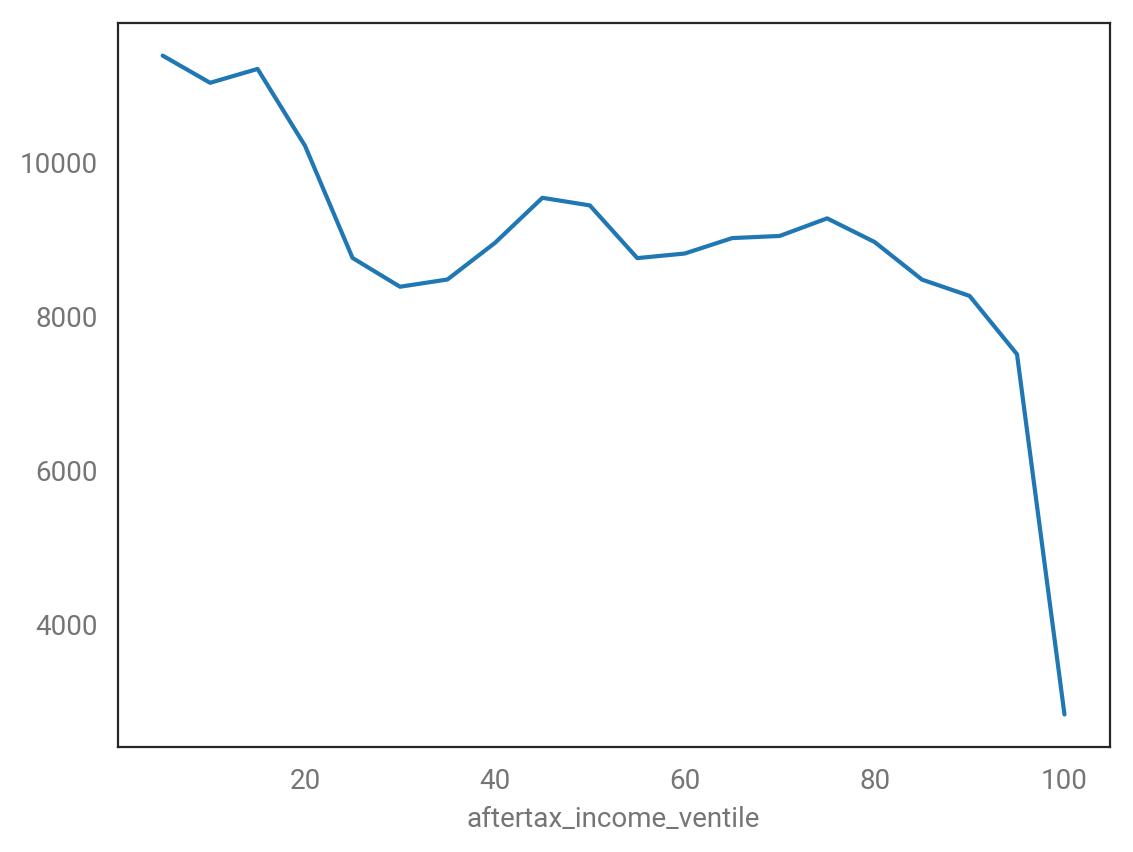

In [54]:
ventile.afti_chg.plot()
plt.show()

### Poverty

In [55]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [56]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

0.05053883636467066

In [57]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

0.010562645231967429

In [58]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()

count    204.00
mean       0.30
std        0.48
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        2.00
Name: adults, dtype: float64